### Merge the sites of each unit with the cluster ID
- for each bird, load `spikesorting_folder / "recording_features_nuclei_estimation.pickle"`
- create a dataframe (in the same location as other unit features) with [bird, cluster_ID, site location, estimated_nuclei, labeled nuclei]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

/mnt/cube/tsainbur/conda_envs/cdcp_paper_cube/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [3]:
from datetime import datetime

In [4]:
from cdcp.spiketrain_analysis.unit_statistics import (
    get_unit_spike_trains,
    get_spike_train_vector,
)

In [21]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [14]:
def nanmode(x):
    vals,counts = np.unique(x, return_counts=True)
    mask = pd.isnull(vals) ==False
    counts = counts[mask]
    vals = vals[mask]
    if len(vals) == 0:
        return np.nan
    return vals[np.argmax(counts)]

In [15]:
def estimate_unit_location(unit_to_analyze, nuclei_locations):
    hemisphere_list = []
    labeled_region_list = []
    estimated_nuclei_list = []
    distance_to_estimated_nuclei_list = []
    ML_list = []
    AP_list = []
    DV_list = []

    for unit, recording_id in unit_to_analyze.sort_units:
        mask = (nuclei_locations.unit.values == unit) & (nuclei_locations.recording_id.values == recording_id)
        if np.sum(mask) == 0:
            continue
        #elif np.sum(mask) > 1:
        #    raise ValueError

        #
        row = nuclei_locations[mask].iloc[0]

        hemisphere_list.append(row.hemisphere)
        labeled_region_list.append(row.labeled_region)
        estimated_nuclei_list.append(row.estimated_nuclei)
        distance_to_estimated_nuclei_list.append(row.distance_to_estimated_nuclei)
        ML_list.append(row.ML)
        AP_list.append(row.AP)
        DV_list.append(row.DV)

    return pd.Series({
        "hemisphere" : nanmode(hemisphere_list),
        "labeled_region" : nanmode(labeled_region_list),
        "estimated_nuclei" : nanmode(estimated_nuclei_list),
        "distance_to_estimated_nuclei" : np.nanmedian(distance_to_estimated_nuclei_list),
        "ML" : np.nanmedian(ML_list),
        "AP" : np.nanmedian(AP_list),
        "DV" : np.nanmedian(DV_list)
    })


In [7]:
from sklearn.linear_model import LogisticRegressionCV


def get_unit_location(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    nuclei_locations,
    identifier="unit_location",
    recompute=False,
    parallel=True,
):
    def run():

        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(unit_to_analyze.cluster_id)
        )
        
        if (
            unit_series_save_loc.exists()
            and (recompute is False)
        ):
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        
        location_series = estimate_unit_location(unit_to_analyze, nuclei_locations=nuclei_locations)
        
        unit_series_list.append(location_series)
        
        # save final row
        unit_series = pd.concat(unit_series_list)
        unit_series.to_pickle(unit_series_save_loc)
        return unit_series

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    ('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    ('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    ('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    ('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [9]:
min_playbacks = 1000

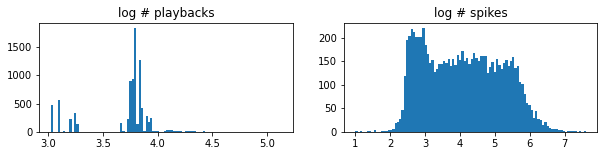

B1597 total # merged units: 8711


unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8711 out of 8711 | elapsed:   31.0s finished


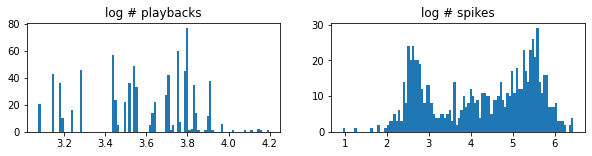

B1188 total # merged units: 821


unit:   0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 821 out of 821 | elapsed:    2.2s finished


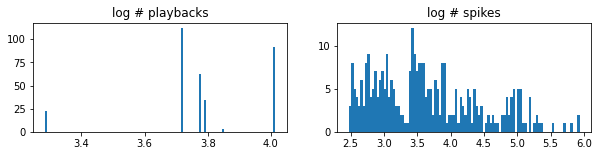

B1595 total # merged units: 325


unit:   0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    0.9s finished


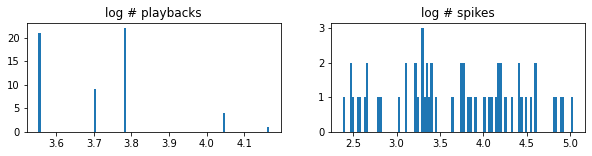

B1276 total # merged units: 57


unit:   0%|          | 0/57 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.2s finished


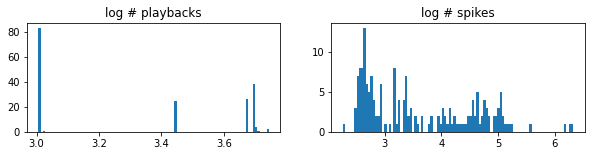

B1426 total # merged units: 180


unit:   0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.5s finished


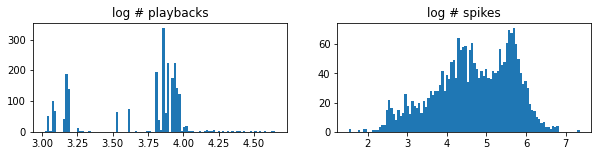

B1432 total # merged units: 2364


unit:   0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2364 out of 2364 | elapsed:    6.9s finished


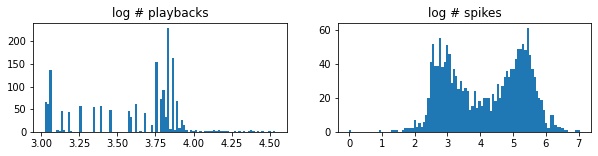

B1170 total # merged units: 1693


unit:   0%|          | 0/1693 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1693 out of 1693 | elapsed:    4.8s finished


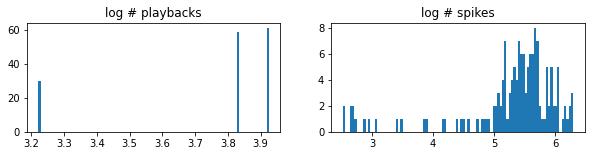

B1244 total # merged units: 150


unit:   0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


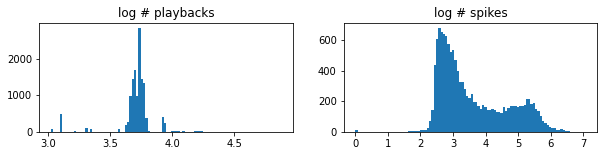

B1593 total # merged units: 13260


unit:   0%|          | 0/13260 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 13260 out of 13260 | elapsed:   51.0s finished


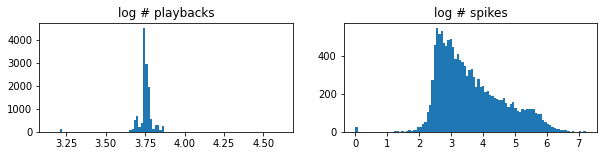

B1248 total # merged units: 13184


unit:   0%|          | 0/13184 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 13184 out of 13184 | elapsed:   47.0s finished


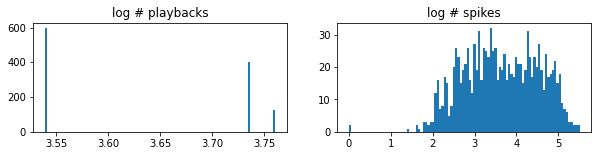

B1279 total # merged units: 1126


unit:   0%|          | 0/1126 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1126 out of 1126 | elapsed:    3.0s finished


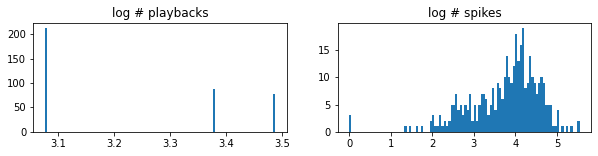

B1500 total # merged units: 377


unit:   0%|          | 0/377 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:    1.0s finished


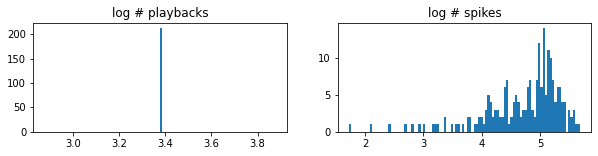

B1239 total # merged units: 212


unit:   0%|          | 0/212 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:    0.6s finished


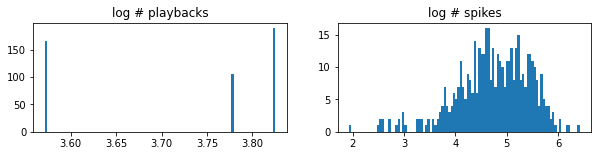

B1459 total # merged units: 460


unit:   0%|          | 0/460 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:    1.2s finished


In [16]:
for bird, timestamp, sorter in birds:
    spikesorting_folder = DATA_DIR / "spikesorting" / bird / timestamp
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")

    # get units that are to be merged
    merged_units = pd.read_pickle(spikesorting_folder / "unit_clusters2.pickle")
    merged_units = merged_units.sort_values(by="n_playbacks", ascending=False)
    merged_units = merged_units[
        merged_units.n_playbacks.astype("float") > min_playbacks
    ]

    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10, 2))
        axs[0].hist(
            np.log10(merged_units.n_playbacks.values.astype("float") + 1), bins=100
        )
        axs[0].set_title("log # playbacks")
        axs[1].hist(
            np.log10(merged_units.n_spikes.values.astype("float") + 1), bins=100
        )
        axs[1].set_title("log # spikes")
        plt.show()
        print("{} total # merged units: {}".format(bird, len(merged_units)))

    ensure_dir(spikesorting_folder / "unit_statistics" / statistics_timestamp)

    nuclei_locations = pd.read_pickle(
        spikesorting_folder / "recording_features_nuclei_estimation2.pickle"
    )
    nuclei_locations = nuclei_locations[
        [
            "unit",
            "recording_id",
            "ML",
            "AP",
            "DV",
            "labeled_region",
            "hemisphere",
            "estimated_nuclei",
            "distance_to_estimated_nuclei",
        ]
    ]

    Parallel(n_jobs=1, verbose=10)(
        delayed(get_unit_location)(
            unit_to_analyze,
            spikesorting_folder,
            statistics_timestamp,
            nuclei_locations=nuclei_locations,
            identifier="unit_location",
            recompute=True,
            parallel=True,
        )
        for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        )
    )

### Debugging

In [11]:
breakme

NameError: name 'breakme' is not defined

In [12]:
np.where(merged_units.cluster_id == 5178)

(array([], dtype=int64),)

In [13]:
Parallel(n_jobs = 1, verbose=10)(
    delayed(get_unit_location)(
        unit_to_analyze,
        spikesorting_folder,
        statistics_timestamp,
        identifier = 'unit_location',
        nuclei_locations=nuclei_locations,
        recompute=True,
        parallel=False,
    )
    for uniti, unit_to_analyze in tqdm(
        merged_units[2:].iterrows(), desc="unit", total=len(merged_units)
    )
);


unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


NameError: name 'nanmode' is not defined

### make dataframe

In [17]:
identifier = "unit_location"

In [18]:
ensure_dir(DATA_DIR / 'unit_statistics' / statistics_timestamp / identifier)

In [19]:
def read_and_unit(i):
    try:
        df = pd.read_pickle(i)
        df['unit'] = i.stem
        return df
    except:
        return

In [22]:
for bird, timestamp, sorter in tqdm(birds):
    print(bird)
    spikesorting_folder = DATA_DIR / "spikesorting" / bird / timestamp
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")

    unit_series_save_loc = (
        spikesorting_folder / "unit_statistics" / statistics_timestamp / identifier
    )
    unit_pickles = list(unit_series_save_loc.glob("*.pickle"))
    unit_statistics_df = pd.concat(
        Parallel(n_jobs=-1, prefer="threads")(
            delayed(read_and_unit)(i)
            for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
        ),
        axis=1,
    ).T

    unit_statistics_df.to_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )

  0%|          | 0/14 [00:00<?, ?it/s]

B1597


reading pickles:   0%|          | 0/8711 [00:00<?, ?it/s]

B1188


reading pickles:   0%|          | 0/821 [00:00<?, ?it/s]

B1595


reading pickles:   0%|          | 0/325 [00:00<?, ?it/s]

B1276


reading pickles:   0%|          | 0/57 [00:00<?, ?it/s]

B1426


reading pickles:   0%|          | 0/180 [00:00<?, ?it/s]

B1432


reading pickles:   0%|          | 0/2364 [00:00<?, ?it/s]

B1170


reading pickles:   0%|          | 0/1693 [00:00<?, ?it/s]

B1244


reading pickles:   0%|          | 0/150 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/13260 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/13184 [00:00<?, ?it/s]

B1279


reading pickles:   0%|          | 0/1126 [00:00<?, ?it/s]

B1500


reading pickles:   0%|          | 0/377 [00:00<?, ?it/s]

B1239


reading pickles:   0%|          | 0/212 [00:00<?, ?it/s]

B1459


reading pickles:   0%|          | 0/460 [00:00<?, ?it/s]

In [ ]:
breakme

### testing

In [ ]:
# load 

In [ ]:
bird

In [ ]:
nuclei_locations[:3]

In [ ]:
nuclei_locations[["unit","recording_id","ML","AP","DV","labeled_region","hemisphere","estimated_nuclei","distance_to_estimated_nuclei"]][:3]

In [ ]:
for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        ):
    break


In [ ]:
def nanmode(x):
    vals,counts = np.unique(x, return_counts=True)
    mask = pd.isnull(vals) ==False
    counts = counts[mask]
    vals = vals[mask]
    if len(vals) == 0:
        return np.nan
    return vals[np.argmax(counts)]

In [ ]:
hemisphere = nanmode(hemisphere_list)
labeled_region = nanmode(labeled_region_list)
estimated_nuclei = nanmode(estimated_nuclei_list)
distance_to_estimated_nuclei = np.nanmedian(distance_to_estimated_nuclei_list)
ML = np.nanmedian(ML_list)
AP = np.nanmedian(AP_list)
DV = np.nanmedian(DV_list)
distance_to_estimated_nuclei

In [ ]:
nanmode([0, 1, np.nan, np.nan])

In [ ]:
vals,counts = np.unique([0, 1, np.nan, np.nan], return_counts=True)
mask = np.isnan(vals)
vals,counts

In [ ]:
np.nanmedian(ML_list)